In [1]:
import tensorflow as tf
print(tf.__version__)

2.3.0


In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

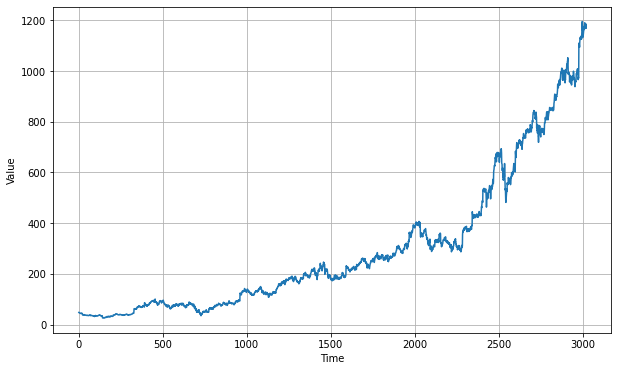

In [4]:
import csv
time_step = []
temps = []

with open('/content/AMZN_2006-01-01_to_2018-01-01.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  step=0
  for row in reader:
    temps.append(float(row[4]))
    time_step.append(step)
    step = step + 1

series = np.array(temps)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [5]:
split_time = 2500
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000


In [6]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [7]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [8]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(2500,)
Epoch 1/100
10/10 [==============================] - 1s 53ms/step - loss: 171.2466 - mae: 171.7465
Epoch 2/100
10/10 [==============================] - 0s 49ms/step - loss: 168.9296 - mae: 169.4294
Epoch 3/100
10/10 [==============================] - 1s 52ms/step - loss: 165.8050 - mae: 166.3048
Epoch 4/100
10/10 [==============================] - 0s 48ms/step - loss: 162.1520 - mae: 162.6518
Epoch 5/100
10/10 [==============================] - 1s 52ms/step - loss: 158.0779 - mae: 158.5776
Epoch 6/100
10/10 [==============================] - 1s 52ms/step - loss: 153.6196 - mae: 154.1193
Epoch 7/100
10/10 [==============================] - 1s 51ms/step - loss: 148.7405 - mae: 149.2402
Epoch 8/100
10/10 [==============================] - 1s 50ms/step - loss: 143.2825 - mae: 143.7823
Epoch 9/100
10/10 [==============================] - 1s 53ms/step - loss: 137.1946 - mae: 137.6943
Epoch 1

(1e-08, 0.0001, 0.0, 60.0)

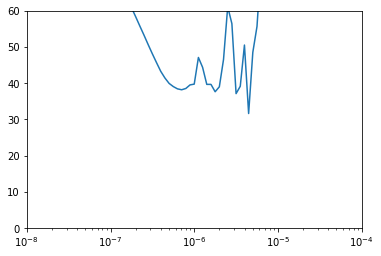

In [9]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [12]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=120, batch_size=64, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=100)

Epoch 1/100
38/38 [==============================] - 2s 52ms/step - loss: 61.8773 - mae: 62.3751
Epoch 2/100
38/38 [==============================] - 2s 52ms/step - loss: 89.7577 - mae: 90.2567
Epoch 3/100
38/38 [==============================] - 2s 51ms/step - loss: 86.0592 - mae: 86.5579
Epoch 4/100
38/38 [==============================] - 2s 53ms/step - loss: 112.9859 - mae: 113.4853
Epoch 5/100
38/38 [==============================] - 2s 53ms/step - loss: 108.1741 - mae: 108.6735
Epoch 6/100
38/38 [==============================] - 2s 52ms/step - loss: 112.4785 - mae: 112.9778
Epoch 7/100
38/38 [==============================] - 2s 52ms/step - loss: 110.4177 - mae: 110.9171
Epoch 8/100
38/38 [==============================] - 2s 52ms/step - loss: 110.5727 - mae: 111.0719
Epoch 9/100
38/38 [==============================] - 2s 52ms/step - loss: 112.0258 - mae: 112.5251
Epoch 10/100
38/38 [==============================] - 2s 52ms/step - loss: 111.0141 - mae: 111.5134
Epoch 11/100
38

In [13]:
model.save('ts.h5')

In [14]:

import os
print(str(os.path.getsize('./ts.h5')/1000000) + 'MB')

0.548496MB
